In [6]:
from sklearn.metrics import fbeta_score, make_scorer, ConfusionMatrixDisplay, classification_report, confusion_matrix
from utils.data_loader import load_split, prepare_features_target
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from utils.learning_curve import learning_curve_with_resampling
from imblearn.pipeline import Pipeline
from models.manage_models import save_model, load_model

In [7]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [8]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [9]:
def objective_rf_sampling(trial, X, y):
    strategy = trial.suggest_categorical("bal_strategy", ["undersample", "internal_weight"])
    
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300), # Bajamos a 300 para ganar velocidad
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "n_jobs": -1,
        "random_state": 42
    }

    if strategy == "internal_weight":
        param["class_weight"] = "balanced_subsample"
    else:
        param["class_weight"] = None # El balanceo se hace por el sampler externo

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if strategy == "undersample":
            rus = RandomUnderSampler(random_state=42)
            X_tr, y_tr = rus.fit_resample(X_tr, y_tr)

        model = RandomForestClassifier(**param)
        model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        scores.append(fbeta_score(y_val, preds, beta=2))

    return np.mean(scores)

In [10]:
study = optuna.create_study(direction="maximize", study_name='randomforest_opt')
study.optimize(lambda trial: objective_rf_sampling(trial, X_train, y_train), n_trials=30, show_progress_bar=True)

[I 2025-12-24 16:40:03,609] A new study created in memory with name: randomforest_opt
Best trial: 0. Best value: 0.757232:   3%|▎         | 1/30 [00:37<18:19, 37.93s/it]

[I 2025-12-24 16:40:41,538] Trial 0 finished with value: 0.7572320650293743 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 237, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7572320650293743.


Best trial: 1. Best value: 0.763975:   7%|▋         | 2/30 [01:20<18:51, 40.42s/it]

[I 2025-12-24 16:41:23,706] Trial 1 finished with value: 0.7639752628941625 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 268, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 1. Best value: 0.763975:  10%|█         | 3/30 [01:29<11:47, 26.19s/it]

[I 2025-12-24 16:41:32,961] Trial 2 finished with value: 0.7566436473004222 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 158, 'max_depth': 10, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 1. Best value: 0.763975:  13%|█▎        | 4/30 [01:35<07:54, 18.26s/it]

[I 2025-12-24 16:41:39,052] Trial 3 finished with value: 0.7239131329231059 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 149, 'max_depth': 6, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 1. Best value: 0.763975:  17%|█▋        | 5/30 [02:05<09:19, 22.37s/it]

[I 2025-12-24 16:42:08,727] Trial 4 finished with value: 0.7506802058219186 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 1. Best value: 0.763975:  20%|██        | 6/30 [02:23<08:24, 21.01s/it]

[I 2025-12-24 16:42:27,088] Trial 5 finished with value: 0.7571010586141937 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 133, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 1. Best value: 0.763975:  23%|██▎       | 7/30 [02:48<08:33, 22.33s/it]

[I 2025-12-24 16:42:52,144] Trial 6 finished with value: 0.7215609399345213 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 281, 'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.7639752628941625.


Best trial: 7. Best value: 0.791964:  27%|██▋       | 8/30 [03:02<07:15, 19.82s/it]

[I 2025-12-24 16:43:06,578] Trial 7 finished with value: 0.7919641097435082 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 179, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  30%|███       | 9/30 [03:34<08:11, 23.38s/it]

[I 2025-12-24 16:43:37,794] Trial 8 finished with value: 0.753505470686562 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 245, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  33%|███▎      | 10/30 [03:46<06:37, 19.85s/it]

[I 2025-12-24 16:43:49,748] Trial 9 finished with value: 0.7820023199282673 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 162, 'max_depth': 17, 'min_samples_leaf': 9}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  37%|███▋      | 11/30 [04:00<05:47, 18.31s/it]

[I 2025-12-24 16:44:04,568] Trial 10 finished with value: 0.7823707178355376 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 201, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  40%|████      | 12/30 [04:15<05:09, 17.19s/it]

[I 2025-12-24 16:44:19,178] Trial 11 finished with value: 0.782413333883776 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 200, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  43%|████▎     | 13/30 [04:23<04:03, 14.31s/it]

[I 2025-12-24 16:44:26,857] Trial 12 finished with value: 0.7826170292507555 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  47%|████▋     | 14/30 [04:31<03:21, 12.60s/it]

[I 2025-12-24 16:44:35,521] Trial 13 finished with value: 0.7886644416432393 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 109, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  50%|█████     | 15/30 [04:40<02:49, 11.31s/it]

[I 2025-12-24 16:44:43,832] Trial 14 finished with value: 0.7886904831526119 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 102, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  53%|█████▎    | 16/30 [04:54<02:49, 12.11s/it]

[I 2025-12-24 16:44:57,808] Trial 15 finished with value: 0.7870773183548442 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 184, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  57%|█████▋    | 17/30 [05:03<02:26, 11.30s/it]

[I 2025-12-24 16:45:07,233] Trial 16 finished with value: 0.7829141485651165 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 124, 'max_depth': 20, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  60%|██████    | 18/30 [05:19<02:32, 12.70s/it]

[I 2025-12-24 16:45:23,200] Trial 17 finished with value: 0.7864807084624366 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 212, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  63%|██████▎   | 19/30 [05:32<02:21, 12.84s/it]

[I 2025-12-24 16:45:36,360] Trial 18 finished with value: 0.7756523852944598 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  67%|██████▋   | 20/30 [05:43<02:02, 12.28s/it]

[I 2025-12-24 16:45:47,321] Trial 19 finished with value: 0.7879364174762973 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 131, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  70%|███████   | 21/30 [05:59<01:59, 13.29s/it]

[I 2025-12-24 16:46:02,988] Trial 20 finished with value: 0.7738566822068356 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 223, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  73%|███████▎  | 22/30 [06:08<01:35, 11.90s/it]

[I 2025-12-24 16:46:11,636] Trial 21 finished with value: 0.7886824998404223 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 101, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  77%|███████▋  | 23/30 [06:17<01:18, 11.24s/it]

[I 2025-12-24 16:46:21,348] Trial 22 finished with value: 0.7865431166294881 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 117, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  80%|████████  | 24/30 [06:28<01:07, 11.20s/it]

[I 2025-12-24 16:46:32,433] Trial 23 finished with value: 0.7836046438363482 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 140, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  83%|████████▎ | 25/30 [06:53<01:16, 15.22s/it]

[I 2025-12-24 16:46:57,038] Trial 24 finished with value: 0.7877386414340473 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 298, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  87%|████████▋ | 26/30 [07:02<00:53, 13.40s/it]

[I 2025-12-24 16:47:06,198] Trial 25 finished with value: 0.7862948486093926 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 109, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  90%|█████████ | 27/30 [07:11<00:36, 12.05s/it]

[I 2025-12-24 16:47:15,094] Trial 26 finished with value: 0.7898648477839375 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 100, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  93%|█████████▎| 28/30 [07:27<00:26, 13.10s/it]

[I 2025-12-24 16:47:30,656] Trial 27 finished with value: 0.7905629735247964 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 181, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964:  97%|█████████▋| 29/30 [07:42<00:13, 13.93s/it]

[I 2025-12-24 16:47:46,527] Trial 28 finished with value: 0.7888422335558016 and parameters: {'bal_strategy': 'undersample', 'n_estimators': 184, 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.7919641097435082.


Best trial: 7. Best value: 0.791964: 100%|██████████| 30/30 [08:03<00:00, 16.13s/it]

[I 2025-12-24 16:48:07,562] Trial 29 finished with value: 0.7386651442905436 and parameters: {'bal_strategy': 'internal_weight', 'n_estimators': 170, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.7919641097435082.


In [11]:
optuna.visualization.plot_optimization_history(study)

In [12]:
optuna.visualization.plot_param_importances(study)

In [13]:
optuna.visualization.plot_contour(study, params=["max_depth", "bal_strategy"])

In [14]:
best_params = study.best_params
under = best_params.pop('bal_strategy')
best_model = RandomForestClassifier(**best_params)
pipeline = Pipeline([
    ('sampler', RandomUnderSampler(random_state=42)),
    ('model', best_model)
])

Folds CV:   0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.9582, Val F2: 0.7734
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.9539, Val F2: 0.7833
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.9447, Val F2: 0.7876
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.9400, Val F2: 0.7910
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.9345, Val F2: 0.7908
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.9311, Val F2: 0.7913
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.9290, Val F2: 0.7994
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  20%|██        | 1/5 [01:39<06:36, 99.13s/it]

  Tamaño 64000 -> Train F2: 0.9262, Val F2: 0.7968

Fold 2/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.9579, Val F2: 0.7683
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.9549, Val F2: 0.7743
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.9454, Val F2: 0.7811
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.9376, Val F2: 0.7863
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.9397, Val F2: 0.7901
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.9358, Val F2: 0.7933
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.9325, Val F2: 0.7956
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  40%|████      | 2/5 [03:18<04:57, 99.15s/it]

  Tamaño 64000 -> Train F2: 0.9304, Val F2: 0.7955

Fold 3/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.9592, Val F2: 0.7591
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.9497, Val F2: 0.7639
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.9448, Val F2: 0.7727
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.9412, Val F2: 0.7742
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.9373, Val F2: 0.7801
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.9342, Val F2: 0.7807
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.9288, Val F2: 0.7830
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  60%|██████    | 3/5 [04:57<03:18, 99.24s/it]

  Tamaño 64000 -> Train F2: 0.9302, Val F2: 0.7852

Fold 4/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.9586, Val F2: 0.7483
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.9506, Val F2: 0.7643
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.9474, Val F2: 0.7787
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.9401, Val F2: 0.7765
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.9372, Val F2: 0.7777
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.9315, Val F2: 0.7814
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.9305, Val F2: 0.7830
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV:  80%|████████  | 4/5 [06:36<01:39, 99.11s/it]

  Tamaño 64000 -> Train F2: 0.9289, Val F2: 0.7852

Fold 5/5
Datos originales -> Train: 64000, Val: 16000
Distribución clase 1 -> Train: 19840, Val: 4960
  Tamaño 6400 -> Resampling: 6400 → 3968 muestras
  Tamaño 6400 -> Train F2: 0.9547, Val F2: 0.7617
  Tamaño 14628 -> Resampling: 14628 → 9070 muestras
  Tamaño 14628 -> Train F2: 0.9461, Val F2: 0.7729
  Tamaño 22857 -> Resampling: 22857 → 14172 muestras
  Tamaño 22857 -> Train F2: 0.9493, Val F2: 0.7762
  Tamaño 31085 -> Resampling: 31085 → 19272 muestras
  Tamaño 31085 -> Train F2: 0.9419, Val F2: 0.7845
  Tamaño 39314 -> Resampling: 39314 → 24374 muestras
  Tamaño 39314 -> Train F2: 0.9419, Val F2: 0.7907
  Tamaño 47542 -> Resampling: 47542 → 29476 muestras
  Tamaño 47542 -> Train F2: 0.9383, Val F2: 0.7919
  Tamaño 55771 -> Resampling: 55771 → 34578 muestras
  Tamaño 55771 -> Train F2: 0.9321, Val F2: 0.7901
  Tamaño 64000 -> Resampling: 64000 → 39680 muestras


Folds CV: 100%|██████████| 5/5 [08:16<00:00, 99.21s/it]

  Tamaño 64000 -> Train F2: 0.9325, Val F2: 0.7970


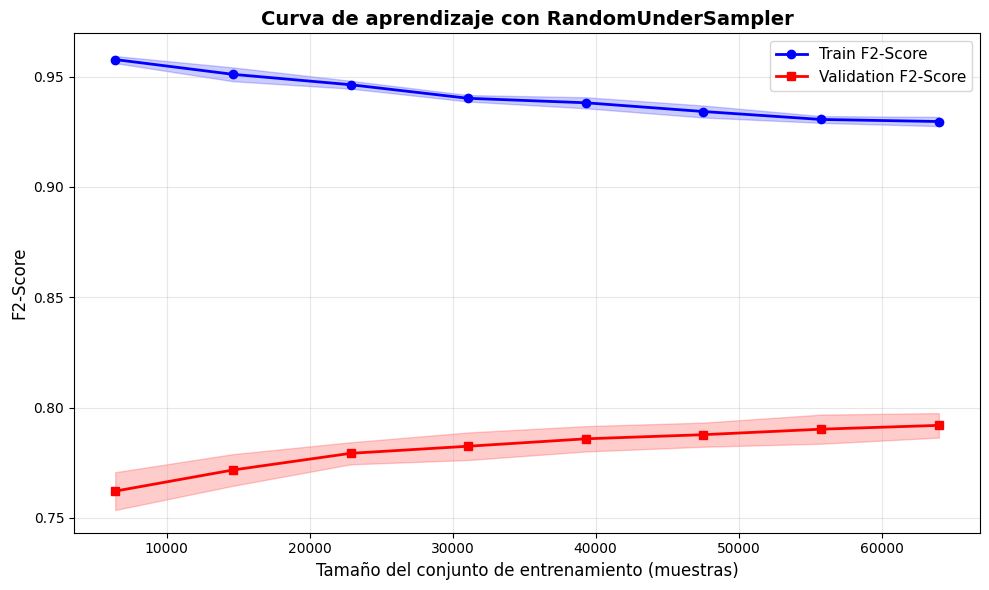


RESUMEN DE LA CURVA DE APRENDIZAJE
Mejor tamaño de entrenamiento: 64000 muestras
Mejor F2-Score en validación: 0.7920 (±0.0055)
F2-Score correspondiente en train: 0.9296
Técnica de resampling: RandomUnderSampler


In [15]:
result = learning_curve_with_resampling(
    estimator=best_model,
    sampler= RandomUnderSampler(),
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    verbose=True,
    use_tqdm=True
)

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=19, min_samples_leaf=3,
                                        n_estimators=179))])

In [17]:
test_df = load_split('test', data_dir='dataset/splits')
X_test, y_test = prepare_features_target(test_df, target_col='Fault')

f2_scorer en test: 0.8484060253450618
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     13800
         1.0       0.78      0.80      0.79      6200

    accuracy                           0.87     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.87      0.87      0.87     20000

Matriz de confusión:


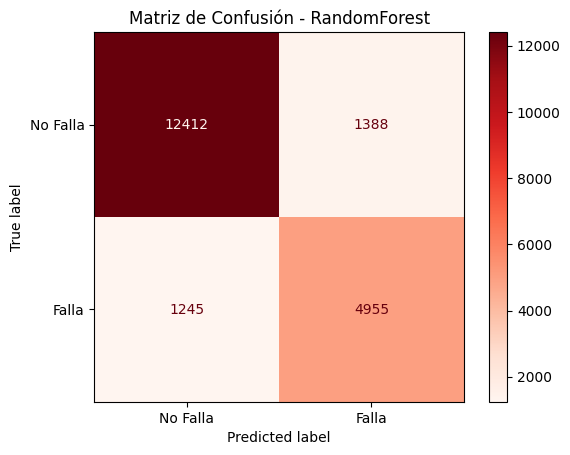

In [18]:
y_pred = pipeline.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - RandomForest')
plt.show()

Probemos combinar xgboost y randomforest

In [19]:
xgboost = load_model('probl1_xgboost', 'models/probl1_xgboost_20251222_153103.joblib')

In [20]:
ensemble_final = VotingClassifier(
    estimators=[('xgb', xgboost), ('rf', pipeline)],
    voting='soft',
    weights=None 
)

ensemble_final.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=0.006742040731588818,
                                            base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9864034240486679,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,
                                            gamma=3.459371333534247e-07...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=17, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, ...)),
                             ('rf',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=42)),
                                              ('model',
                                               RandomForestClassifier(max_depth=19,
                                                                      min_samples_leaf=3,
                                                                      n_estimators=179))]))],
                 voting='soft')

f2_scorer en test: 0.8426827809991475
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90     13800
         1.0       0.77      0.79      0.78      6200

    accuracy                           0.86     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.86      0.86      0.86     20000

Matriz de confusión:


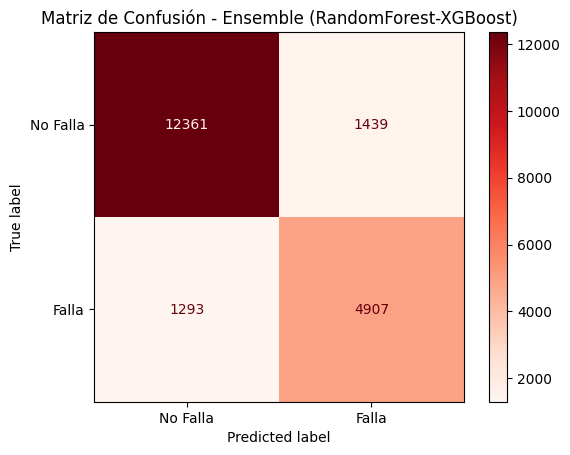

In [21]:
y_pred = ensemble_final.predict(X_test)

print("f2_scorer en test:",
      fbeta_score(y_test, y_pred, beta=2, average="macro"))
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
# Plot it using the ConfusionMatrixDisplay imported
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['No Falla', 'Falla'],
                             )
disp.plot(cmap='Reds')
plt.title('Matriz de Confusión - Ensemble (RandomForest-XGBoost)')
plt.show()

In [22]:
paths = save_model(
    model=pipeline, 
    model_name='probl1_randomforest',
    save_path='models/',
    metadata={
        'augmented': False,
        'undersampled': True,
        'scaler_applied': False,
        'hyperparameters': pipeline.get_params()
    }
)

print(f"Modelo guardado en: {paths['model_path']}")

Modelo guardado en: models/probl1_randomforest_20251224_165932.joblib
